Exploratory Data Analysis

In [50]:
import pandas as pd

cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")

/var/folders/bx/bzgj6qhd5_l2_b7d0v7r7r7r0000gn/T/ipykernel_3548/1667466518.py:4: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


In [51]:
#User Lifetime Value (uLTV)

# Hypothesis: Users with longer active periods generate more revenue through fees.
# Metric: Total accepted fee amount per user, normalized by active months.
# Columns:
# From fees: total_amount, cash_request_id, status
# From cash requests: id, user_id, created_at

/var/folders/bx/bzgj6qhd5_l2_b7d0v7r7r7r0000gn/T/ipykernel_3548/1102741501.py:8: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


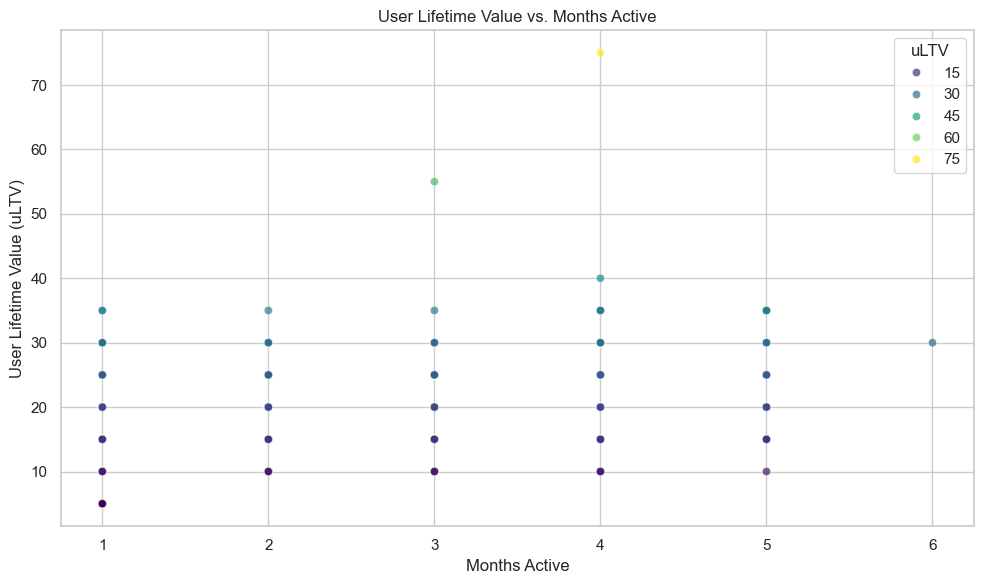

In [52]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load datasets
cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")

# Step 2: Filter only accepted fees
accepted_fees_df = fees_df[fees_df["fee_status"] == "accepted"]

# Step 3: Merge with cash requests
merged_df = accepted_fees_df.merge(
    cashrequest_df[["cash_request_id", "user_id", "cash_request_created_at"]],
    on="cash_request_id",
    how="left"
)

# Step 4: Handle datetime and ID columns safely
if "cash_request_created_at_y" in merged_df.columns:
    merged_df["created_at"] = pd.to_datetime(merged_df["cash_request_created_at_y"], errors="coerce")
else:
    merged_df["created_at"] = pd.to_datetime(merged_df["cash_request_created_at"], errors="coerce")

if "user_id_y" in merged_df.columns:
    merged_df["user_id"] = merged_df["user_id_y"]

# Step 5: Drop rows with invalid or missing dates
merged_df = merged_df.dropna(subset=["created_at"])

# Step 6: Calculate months active per user
user_activity = merged_df.groupby("user_id")["created_at"].agg(["min", "max"]).reset_index()
user_activity["months_active"] = ((user_activity["max"] - user_activity["min"]) / pd.Timedelta(days=30)).apply(lambda x: max(1, round(x)))

# Step 7: Count number of accepted fees per user
user_tx_count = merged_df.groupby("user_id").size().reset_index(name="num_transactions")

# Step 8: Sum total accepted fees per user
user_fees = merged_df.groupby("user_id")["total_amount"].sum().reset_index()
user_fees.rename(columns={"total_amount": "total_fees"}, inplace=True)

# Step 9: Merge all components
final_df = user_fees.merge(user_tx_count, on="user_id").merge(user_activity[["user_id", "months_active"]], on="user_id")

# Step 10: Calculate uLTV components
final_df["avg_transaction_value"] = final_df["total_fees"] / final_df["num_transactions"]
final_df["transaction_frequency"] = final_df["num_transactions"] / final_df["months_active"]
final_df["uLTV"] = final_df["avg_transaction_value"] * final_df["transaction_frequency"] * final_df["months_active"]

# Step 11: Sort by uLTV descending
final_df = final_df.sort_values(by="uLTV", ascending=False)

# Step 12: Save output
os.makedirs("output", exist_ok=True)
final_df.to_csv("output/user_fees_by_month.csv", index=False)

# Step 13: Plot uLTV vs Months Active
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=final_df,
    x="months_active",
    y="uLTV",
    hue="uLTV",
    palette="viridis",
    alpha=0.7
)
plt.title("User Lifetime Value vs. Months Active")
plt.xlabel("Months Active")
plt.ylabel("User Lifetime Value (uLTV)")
plt.tight_layout()
plt.show()


In [53]:
# uLTV stands for User Lifetime Value
# It represents the total revenue generated by a user over their active period
# In your case, it’s based on accepted fees only
# The unit is the same as your total_amount column (€)

In [54]:
# How to read it:

# Each dot = 1 user
# X-axis = Months Active
# Y-axis = uLTV (total value per user)
# Color = Value intensity (lighter = higher uLTV)

# Example:
# A user at months_active = 3 and uLTV = 60 means: They were active for 3 months and generated €60 in total.

/var/folders/bx/bzgj6qhd5_l2_b7d0v7r7r7r0000gn/T/ipykernel_3548/854297741.py:7: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


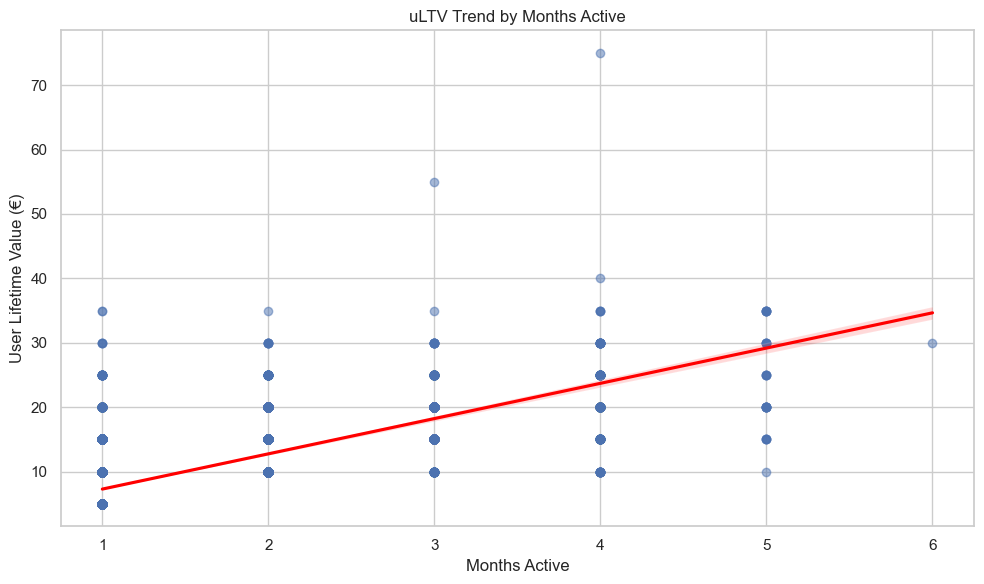

Top 10% Users by uLTV:
      user_id  uLTV
1617    17144  75.0
1173    12934  55.0
1814    18984  40.0
1443    15493  35.0
366      4982  35.0
...       ...   ...
1900    19697  15.0
1899    19692  15.0
1895    19650  15.0
1891    19622  15.0
7351    88236  15.0

[1741 rows x 2 columns]


In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load datasets
cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")

# Step 2: Filter only accepted fees
accepted_fees_df = fees_df[fees_df["fee_status"] == "accepted"]

# Step 3: Merge fees with cash requests (to get user_id, created_at)
merged_df = accepted_fees_df.merge(
    cashrequest_df[["cash_request_id", "user_id", "cash_request_created_at"]],
    on="cash_request_id",
    how="left"
)

# Ensure we have a proper 'user_id' column
if "user_id_y" in merged_df.columns:
    merged_df["user_id"] = merged_df["user_id_y"]

# Use the correct created_at column
if "cash_request_created_at_y" in merged_df.columns:
    merged_df["created_at"] = pd.to_datetime(merged_df["cash_request_created_at_y"], errors="coerce")
else:
    merged_df["created_at"] = pd.to_datetime(merged_df["cash_request_created_at"], errors="coerce")

# Step 4: Drop invalid dates
merged_df = merged_df.dropna(subset=["created_at"])

# Step 5: Calculate months active per user
user_activity = merged_df.groupby("user_id")["created_at"].agg(["min", "max"]).reset_index()
user_activity["months_active"] = ((user_activity["max"] - user_activity["min"]) / pd.Timedelta(days=30)).apply(lambda x: max(1, round(x)))

# Step 6: Count accepted fees per user
user_tx_count = merged_df.groupby("user_id").size().reset_index(name="num_transactions")

# Step 7: Total accepted fee amount per user
user_fees = merged_df.groupby("user_id")["total_amount"].sum().reset_index()
user_fees.rename(columns={"total_amount": "total_fees"}, inplace=True)

# Step 8: Merge all components
final_df = user_fees.merge(user_tx_count, on="user_id") \
                    .merge(user_activity[["user_id", "months_active"]], on="user_id")

# Step 9: Calculate uLTV components
final_df["avg_transaction_value"] = final_df["total_fees"] / final_df["num_transactions"]
final_df["transaction_frequency"] = final_df["num_transactions"] / final_df["months_active"]
final_df["uLTV"] = final_df["avg_transaction_value"] * final_df["transaction_frequency"] * final_df["months_active"]

# ------------------------------------------
# 1. uLTV Trend Line vs. Months Active
# ------------------------------------------
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(data=final_df, x="months_active", y="uLTV", scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title("uLTV Trend by Months Active")
plt.xlabel("Months Active")
plt.ylabel("User Lifetime Value (€)")
plt.tight_layout()
plt.show()

# ------------------------------------------
# 2. Export Top 10% Users by uLTV
# ------------------------------------------
threshold = final_df["uLTV"].quantile(0.90)
top_10_df = final_df[final_df["uLTV"] >= threshold]
print("Top 10% Users by uLTV:")
print(top_10_df[["user_id", "uLTV"]].sort_values(by="uLTV", ascending=False))


In [56]:
# Users with longer activity tend to generate higher revenue: The trend line slopes upward — suggesting a positive correlation
# Even early users can be high-value: Some users at 1–2 months already show high uLTV
# Retention matters: Increasing months active is correlated with increasing lifetime value
# Strategic Insight: Focus on extending user engagement beyond the first few months to increase overall revenue

In [58]:
""""

📊 Insights from uLTV Trend Analysis

Modest correlation between uLTV and time
While there’s a slight upward trend, most users reach their peak value within the first few months.

High-value users emerge early
A significant number of users generate high uLTV in just 1–2 months, highlighting the importance of strong onboarding and early engagement.

Retention beyond month 4 flattens
uLTV gains taper off after month 3–4, suggesting current long-term engagement strategies may not be unlocking additional value.

Almost no users reach month 6
This could indicate user churn before that point, or a gap in product lifecycle or re-engagement efforts.


📌 Strategic Takeaways

Focus on maximizing value in the first month through onboarding, and marketing actions.
Implement retention loops before month 3 to avoid early drop-off.
Explore why users aren’t reaching month 6 — and design long-term incentives to retain and grow lifetime value over time.

"""

'"\n\n📊 Insights from uLTV Trend Analysis\n\nModest correlation between uLTV and time\nWhile there’s a slight upward trend, most users reach their peak value within the first few months.\n\nHigh-value users emerge early\nA significant number of users generate high uLTV in just 1–2 months, highlighting the importance of strong onboarding and early engagement.\n\nRetention beyond month 4 flattens\nuLTV gains taper off after month 3–4, suggesting current long-term engagement strategies may not be unlocking additional value.\n\nAlmost no users reach month 6\nThis could indicate user churn before that point, or a gap in product lifecycle or re-engagement efforts.\n\n\n📌 Strategic Takeaways\n\nFocus on maximizing value in the first month through onboarding, and marketing actions.\nImplement retention loops before month 3 to avoid early drop-off.\nExplore why users aren’t reaching month 6 — and design long-term incentives to retain and grow lifetime value over time.\n\n'